## Constraints and Priors

In the first tutorial, we saw how we can use Ledidi to design transcription factor binding sites by pairing it with a BPNet model that predicted GATA2. Then, we saw a few approaches for evaluating the designs to ensure they are robust and not just based on some learned spurious correlation. More broady, we saw how to actually use Ledidi with a PyTorch model given a target objective and an initial sequence. 

However, this sort of unconstrained design, where edits can be made anywhere, may not always be ideal in reality. In practice there are likely to be important constraints that cannot be violated, such as not editing key binding sites or transcribed regions, or there may be useful prior knowledge that can guide the design process. Ledidi is able to seamlessly integrate hard constraints and also soft priors into the design task without the need for any code modifications.

### Constraints

#### Preventing Edits (Gene Bodies)

The most conceptually straightforward constraint is preventing edits from being made at certain positions. These positions do not have to be contiguous, though they will usually come in the form of one or more spans known to be important. For example, when editing a promoter region, one may with to prevent edits at the TATAA box or within the coding region for the gene. Although using a model that is aware of transcription and setting an appropriate target value edits may implicitly prevent edits at the TATAA box, sometimes having a hard constraint can be useful, particularly when such a model is not readily available. Alternatively, when editing an enhancer, one may wish to preserve binding sites corresponding to long-range activity whose influence may fall outside the scope of the individual region being considered.

This constraint is implemented in Ledidi through the use of a boolean mask over every position, indicating whether edits can be made or not. This provides the user with the most flexibility possible in that any number of spans or even individual positions can be blocked from being edited without additional complexity. Under the hood, this mask is used to set the weights in Ledidi's weight matrix to -inf in each character at those positions except for the one in the initial sequence. This prevents Ledidi from sampling anything other than the original character at those positions.

Let's see this constraint in practice by considering the promoter of the SMYD3 gene, as we do in the paper. SMYD3 is a protein that is broadly expressed across tissues and is associated with remodeling chromatin, and where dysregulation can lead to cancer. In this example, let's try to alter various properties of the region without disturbing the coding region of the gene itself. Because the gene is on the negative strand and we have chosen the TSS as the middle of the region, this means masking out the first 1057 bp. 

First, we can load the region.

In [1]:
import pyfaidx
from tangermeme.utils import one_hot_encode

chrom, mid = 'chr1', 246507312 # Location of the SMYD3 gene TSS
start, end = mid - 1057, mid + 1057 # 2114 bp window

X = pyfaidx.Fasta("../../../../common/hg38.fa")[chrom][start:end].seq.upper()
X = one_hot_encode(X).unsqueeze(0).float().cuda()

Then we can load up models to use for design. Because we are just demonstrating how to do certain types of designs, let's use the GATA2 BPNet model again.

In [2]:
import torch

from bpnetlite import BPNet
from bpnetlite.bpnet import ControlWrapper
from bpnetlite.bpnet import CountWrapper

model = torch.load("../../../../models/bpnet/GATA2.torch", weights_only=False)
model = CountWrapper(ControlWrapper(model)).cuda()

We should first confirm that GATA does not already bind at this region so that increasing GATA binding further is a feasible task.

In [3]:
from tangermeme.predict import predict

predict(model, X)

tensor([[0.4570]])

Great. Because BPNet count predictions are log fold count enrichment over a control, a value near zero means low predicted binding.

Next, we will begin by having Ledidi design edits in an unconstrained manner that significantly increase GATA binding. These edits can be anywhere in the provided region. Then, to demonstrate how to use a mask and that this enforces a hard constraint of no edits being allowed, we will mask out the gene body to prevent any edits from being made after the TSS. And, finally, we will take that mask and incrementally expand it out past the TSS.

In [4]:
import numpy

from tqdm import tqdm
from ledidi import ledidi

y_bar = predict(model, X, device='cuda').cuda() + 4
X_bars_gata = []

X_bar = ledidi(model, X, y_bar, l=0.01, verbose=False)
X_bars_gata.append(X_bar)

for i in tqdm(range(10)):
    input_mask = torch.ones(2114, dtype=bool, device='cuda')
    input_mask[1057 + i*50:] = 0
    
    X_bar = ledidi(model, X, y_bar, l=0.01, input_mask=input_mask, verbose=False)
    X_bars_gata.append(X_bar)
    
X_bars_gata = torch.stack(X_bars_gata)

edits_mask = torch.abs(X_bars_gata - X[:, None]).sum(dim=(1, 2)).numpy(force=True)
edits_mask = numpy.where(edits_mask > 0)

100%|██████████| 10/10 [01:26<00:00,  8.69s/it]


Now we can make a plot showing where the edits are made in the sequence where each row is a differing amount of sequence being protected, with the first row being none of it being protected, and each dot corresponds to the location in the sequence that an edit is being proposed.

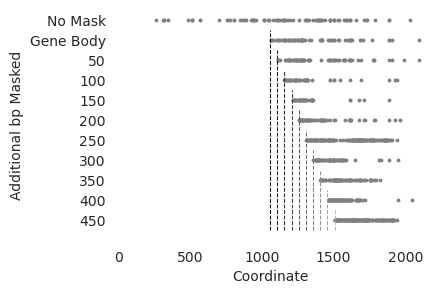

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

plt.figure(figsize=(4, 3))
plt.scatter(edits_mask[1], 10 - edits_mask[0], s=3, c='0.5')

for i in range(10):
    plt.plot([1057+i*50, 1057+i*50], [-0.5, 9.5-i], c=str(0.08*i), linestyle='--', linewidth=0.75)

plt.xlim(-20, 2140)
plt.grid(False)
seaborn.despine(bottom=True, left=True)
plt.yticks(range(11), list(map(str, 450 - numpy.arange(9)*50)) + ['Gene Body', 'No Mask'])
plt.ylabel("Additional bp Masked")
plt.xlabel("Coordinate")
plt.show()

We can make several observations. 

First, when doing the design in an unconstrained manner, Ledidi proposed edits across the entire sequence. This makes sense, and the reason that these edits are so scattered is that likely are taking sites that are almost GATA sites and making one or a small number of changes to subtly pushing them in the right direction.

Second, when using the mask that prevents edits in the gene body (left-most dotted gray line), no edits are proposed in the gene body. This demonstrates that the mask is a hard constraint, not simply a preference that could be overcome with enough pushing by the optimization algorithm.

Third, as we increase the size of the mask, edits are proposed in a smaller and smaller window. Consequently, the edits become more concentrated within the area that edits are allowed to be made. This is because Ledidi is still trying to achieve the same target value as before, but now just has less material to do it with. 

An interesting half-observation is that edits do not seem to be frequently proposed on the flanks of the input window, even when very little space is available for editing. This is likely an artifact of the model where, for whatever reason, the flanks are less influential or potentially even not influential for model predictions. 

#### Preventing Edits (Protein Binding Sites)

Another setting where we may want to prevent edits is when there are known motifs that are important but whose role may not be captured by the predictive model being used. For instance, continuing with the example of editing in GATA binding at a promoter, we may want to block edits from happening at the initiation site or the TATAA box if such a site exists at this promoter. This means that instead of blocking off edits from being made in a big chunk of the region, we want to block out one or more spans (potentially alongside blocking off a big chunk like the gene body).

To demonstrate this, let's use a synthetic site that is entirely randomly generated but has multiple copies of the GATA binding site in it.

In [6]:
from tangermeme.utils import random_one_hot
from tangermeme.ersatz import multisubstitute

motif = 'ACAGATAAGAA'

X = random_one_hot((1, 4, 2114), random_state=0).float().cuda()
X_gata = multisubstitute(X, [motif, motif, motif], spacing=12)

y_bar = predict(model, X_gata).cuda() - 0.5
y_bar

tensor([[1.2434]], device='cuda:0')

Looks like this region starts off with a reasonable amount of GATA binding as we would expect. Now, we can use Ledidi in three settings where we want to diminish, but not completely destroy, GATA binding signal. First, we can use it without any mask to see where it would make edits normally. Then, we can use it when the left half of the sequence is protected and edits cannot be made there. Finally, we will protect the right half of the edits and only make edits on the right portion.

In [7]:
torch.manual_seed(0)
X_bar0 = ledidi(model, X_gata, y_bar)

torch.manual_seed(0)
input_mask = numpy.zeros(2114, dtype=bool)
input_mask[:1057] = True

X_bar1 = ledidi(model, X_gata, y_bar, input_mask=input_mask)

torch.manual_seed(0)
input_mask = numpy.zeros(2114, dtype=bool)
input_mask[1057:] = True

X_bar2 = ledidi(model, X_gata, y_bar, input_mask=input_mask).cuda()

iter=I	input_loss=0.0	output_loss=0.25	total_loss=0.25	time=0.0
iter=100	input_loss=4.125	output_loss=0.01595	total_loss=0.4284	time=1.217
iter=F	input_loss=1.938	output_loss=0.03134	total_loss=0.2251	time=1.892
iter=I	input_loss=0.0	output_loss=0.25	total_loss=0.25	time=0.0
iter=100	input_loss=1.75	output_loss=0.01721	total_loss=0.1922	time=1.214
iter=F	input_loss=1.75	output_loss=0.01373	total_loss=0.1887	time=1.905
iter=I	input_loss=0.0	output_loss=0.25	total_loss=0.25	time=0.0
iter=100	input_loss=2.125	output_loss=0.002378	total_loss=0.2149	time=1.161
iter=F	input_loss=1.688	output_loss=0.02081	total_loss=0.1896	time=1.898


To visualize these edits we will use DeepLIFT/SHAP on the resulting sequences. Remember that we only diminished the original predicted sequence by a little bit, so we would not expect each of the three motifs to be knocked out.

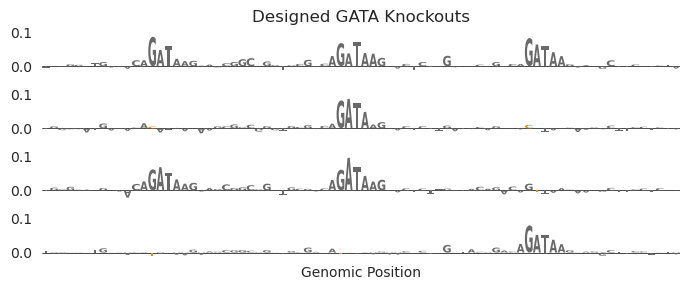

In [8]:
from ledidi.plot import plot_edits
from tangermeme.deep_lift_shap import deep_lift_shap

mid, w = 1057, 40
start, end = mid - w + 2, mid + w

X_attr = deep_lift_shap(model, X_gata)[:, :, start:end]
X_attr0 = deep_lift_shap(model, X_bar0)[:1, :, start:end]
X_attr1 = deep_lift_shap(model, X_bar1)[:1, :, start:end]
X_attr2 = deep_lift_shap(model, X_bar2)[:1, :, start:end]

axs = plot_edits(X_attr, torch.cat([X_attr0, X_attr1, X_attr2], axis=0), figsize=(7, 3))

axs[0].set_title("Designed GATA Knockouts")
plt.xlabel("Genomic Position")
plt.tight_layout()
plt.show()

These results are in line with what we would expect. In the first row, before any design is done, all three motifs exhibit high attribution. In the second row, where the editing is unrestrained, we see that left and right flanking motifs get removed. In the third row, where edits can only be made on the right flank of the sequence, the right flanking motif gets knocked out. In the fourth row, where edits can only be made on the left side, the left flanking motif gets knocked out.

Essentially, we have used the mask to control which binding sites get removed by the editing process, and which ones remain completely in-tact.

#### Preventing Edits (No Added Cs)

So far we have prevented edits of any type from being made at certain positions. However, we get more sophisticated than that and only block certain types of edits from being made. Because we can set any entry in the initial weight matrix to a -inf to prevent that character from being observed, we have complete flexibility over the positioning and composition of the edits. All we have to do is manually create our initial weight matrix and pass it in. Under the hood, modifying this weight matrix is what is happening when you pass in a mask. For example, let's consider an example where we want to block any Cs from being allowed in the sequence.

In [9]:
initial_weights = torch.zeros((1, 4, 2114)).float()
initial_weights[:, 1, :] = float("-inf")

X_bar3 = ledidi(model, X_gata, y_bar, initial_weights=initial_weights).cuda()

iter=I	input_loss=0.0	output_loss=0.25	total_loss=0.25	time=0.0
iter=100	input_loss=526.0	output_loss=0.05333	total_loss=52.65	time=1.173
iter=F	input_loss= 0.0	output_loss=0.25	total_loss=0.25	time=1.173


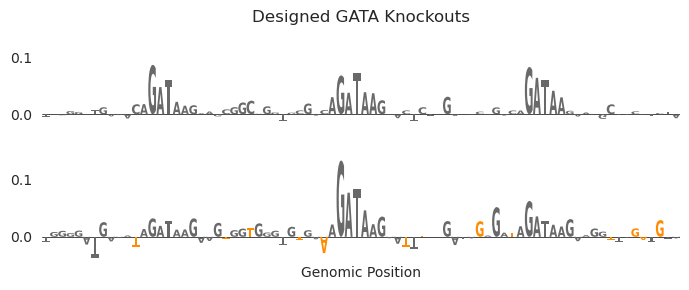

In [10]:
X_attr3 = deep_lift_shap(model, X_bar3)[:1, :, start:end]
axs = plot_edits(X_attr, X_attr3, figsize=(7, 3))

axs[0].set_title("Designed GATA Knockouts")
plt.xlabel("Genomic Position")
plt.tight_layout()
plt.show()

C's do not play a big role in the GATA motif which, notoriously, does not have any C's in it. But you can see that, in addition to our original design task, we have converted all the C's in the sequence into something else while still achieving our design goal.

Likely, you do not actually want to remove all instances of a particular nucleotide from your sequence. But you might want to prevent certain nucleotides from being edited in, potentially due to issues with prime or base editing. To do this, all we have to do is change the initial weight matrix to have a -inf at the C position but only when the initial sequence is not C.initial_weights = torch.zeros((1, 4, 2114)).float()
initial_weights[:, 1, :] = float("-inf")

X_bar3 = ledidi(model, X_gata, y_bar, initial_weights=initial_weights).cuda()

In [11]:
initial_weights = torch.zeros((1, 4, 2114)).float()
initial_weights[:, 1, :] = float("-inf")
initial_weights[0, X_gata.argmax(axis=1)[0], :] = 0

X_bar4 = ledidi(model, X_gata, y_bar, initial_weights=initial_weights).cuda()

iter=I	input_loss=0.0	output_loss=0.25	total_loss=0.25	time=0.0
iter=100	input_loss=2.375	output_loss=0.01549	total_loss=0.253	time=1.162
iter=F	input_loss=2.062	output_loss=0.01364	total_loss=0.2199	time=2.164


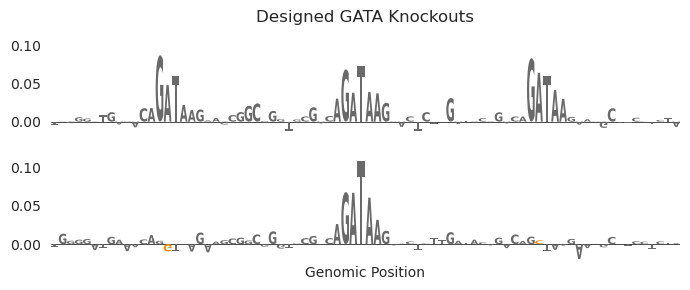

In [12]:
X_attr4 = deep_lift_shap(model, X_bar4)[:1, :, start:end]
axs = plot_edits(X_attr, X_attr4, figsize=(7, 3))

axs[0].set_title("Designed GATA Knockouts")
plt.xlabel("Genomic Position")
plt.tight_layout()
plt.show()

This set of edits seems more reasonable. Positions that were originally C are allowed to remain that way but we cannot add in any more Cs.

Naturally, this concept can be extended past a complete blocking of Cs. Individual positions can be blocked from making specific edits. For instance, the G in each of the GATAA motif might be blocked from becoming a T because that would turn the GATAA into a TATAA, which might have sub-optimal outcomes. Because it is common for protein binding sites to have similar motifs, in high-stakes situations you may need to block some specific edits from being made to prevent the knock-out for one protein to accidentally turn into a knock-in for another one.

#### Adding in Motifs

Although the idea is somewhat contradictory, we can also use careful usage of a mask to force edits to happen -- even editing in an entire motif. In our initial usage of a mask, we set all the characters to -inf except the one in the initial sequence. If we set all the characters to -inf except for some other character, we could force that edit ot be included in the design. Keep in mind that this is not the same as simply making the change before or after running Ledidi. If we made the edit before, Ledidi could potentially remove it. If we made the edit after, the sequence might no longer have the desired properties because other necessary edits were made in that region, or the inclusion of the motif diminishes or increases signal past what one wanted. Conceptually, it is the same as making edits and then masking the region out without needing to alter the initial sequence.

In [13]:
initial_weights = torch.zeros((1, 4, 2114)).float()
initial_weights[:, :, 1050:1060] = float("-inf")
initial_weights[:, [2, 0, 2, 0, 3, 0, 0, 2, 0, 0], range(1050, 1060)] = 0

torch.manual_seed(0)
X_bar5 = ledidi(model, X_gata, y_bar, l=0.01, initial_weights=initial_weights).cuda()

iter=I	input_loss=0.0	output_loss=0.25	total_loss=0.25	time=0.0
iter=100	input_loss=11.5	output_loss=0.002746	total_loss=0.1177	time=1.175
iter=F	input_loss=11.44	output_loss=0.001603	total_loss=0.116	time=2.33


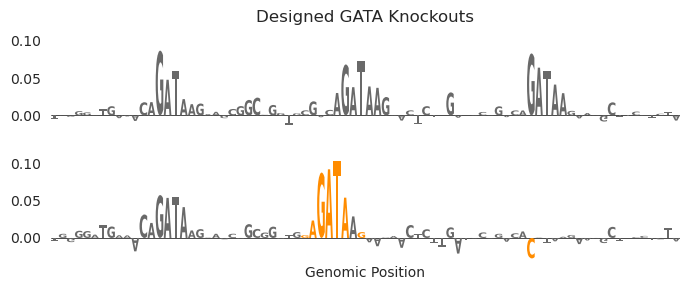

In [14]:
X_attr5 = deep_lift_shap(model, X_bar5)[:1, :, start:end]
axs = plot_edits(X_attr, X_attr5, figsize=(7, 3))

axs[0].set_title("Designed GATA Knockouts")
plt.xlabel("Genomic Position")
plt.tight_layout()
plt.show()

In this example you can see that we have moved the middle GATA motif over by a few nucleotides and still achieved our objective by eliminating the GATA motif on the right flank.

#### Priors

If masks can be thought of as a hard constraint, priors can be viewed as a soft constraint. Rather than forcing a position to not be edited, we can nudge the optimization problem in a certain direction. Using priors does not force Ledidi to design anything in particular (unless the prior is set to such a high value that nothing else is feasible), but simply rewards Ledidi is the priors can be used in a successful design.

Priors are implemented in Ledidi by providing an initial weight matrix that is not just entirely zeroes, like the vanilla Ledidi weight matrix, or zeroes with some -infs in it, as Ledidi does when it has hard constraints. Because this weight matrix encodes logits used in the Gumbel-softmax distribution, positive values mean it is more likely that these values are drawn and negative values mean less likely.

An important note about setting priors like this is that they can be undone by the training procedure and, once undone, are almost as if they were never set at all. Basically, even if set to a high value initially, if the design process takes many steps and each step decreases this value, you may find that those initial values are gone forever.

To see the use of priors in action, we can mimic the masked section by trying to knock out a specific GATA binding site by setting a span of characters in the middle to having a high likelihood of being Cs. Remember that we are not forcing the characters to be Cs (although we could by setting the value to inf instead of just high), but rather just pushing the model in that direction.

In [15]:
initial_weights = torch.zeros((1, 4, 2114)).float()
initial_weights[:, :, 1057-5:1057+5] = 0
initial_weights[:, 1, 1057-5:1057+5] = 1000

torch.manual_seed(0)
X_bar6 = ledidi(model, X_gata, y_bar, l=0.01, initial_weights=initial_weights).cuda()

iter=I	input_loss=0.0	output_loss=0.25	total_loss=0.25	time=0.0
iter=100	input_loss=16.75	output_loss=0.001271	total_loss=0.1688	time=1.17
iter=200	input_loss=22.31	output_loss=0.003895	total_loss=0.227	time=1.166
iter=F	input_loss=13.62	output_loss=0.003672	total_loss=0.1399	time=2.43


And we can visualize the results in the same way as before. 

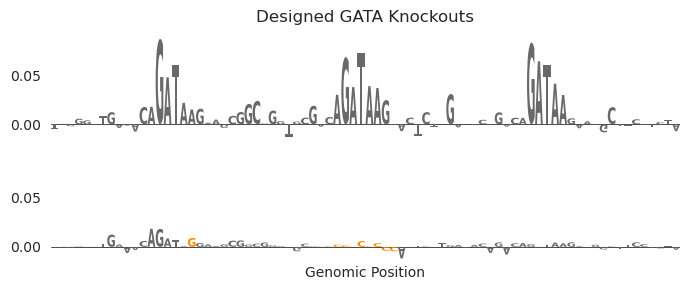

In [16]:
X_attr6 = deep_lift_shap(model, X_bar6)[:1, :, start:end]
axs = plot_edits(X_attr, X_attr6, figsize=(7, 3))

axs[0].set_title("Designed GATA Knockouts")
plt.xlabel("Genomic Position")
plt.tight_layout()
plt.show()

It is a little difficult to see, but there is a span of C's in the middle there that are all edits.

### Conclusions

Hard constraints and soft priors can be important components of design. These tools allow you to incorporate prior knowledge into the design either in the form of knowing things that cannot be touched (but may not be known about by the model being used for design), or knowledge about types of edits that might be experimentally challenging to achieve. As we have seen, Ledidi is able to seamlessly incorporate both types of constraints into the design process, meaning that you do not have to post-hoc account for any inconveniences caused by an unconstrained design process.